# Фильтр Кальмана (для восстановление данных с отрицательными значениями)

### Библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
from numpy import ma
from pykalman import KalmanFilter
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import os

 ### данные с пропусками

In [2]:
data = pd.read_csv('C:/pythonushka/missing_negative_value.csv')
df = data
print(data)
print(data.info())


            date       value
0     2018-01-01     784.288
1     2018-01-02         NaN
2     2018-01-03         NaN
3     2018-01-04         NaN
4     2018-01-05         NaN
...          ...         ...
1456  2021-12-27         NaN
1457  2021-12-28         NaN
1458  2021-12-29         NaN
1459  2021-12-30         NaN
1460  2021-12-31  659746.694

[1461 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1461 non-null   object 
 1   value   1094 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.0+ KB
None


<AxesSubplot:xlabel='date'>

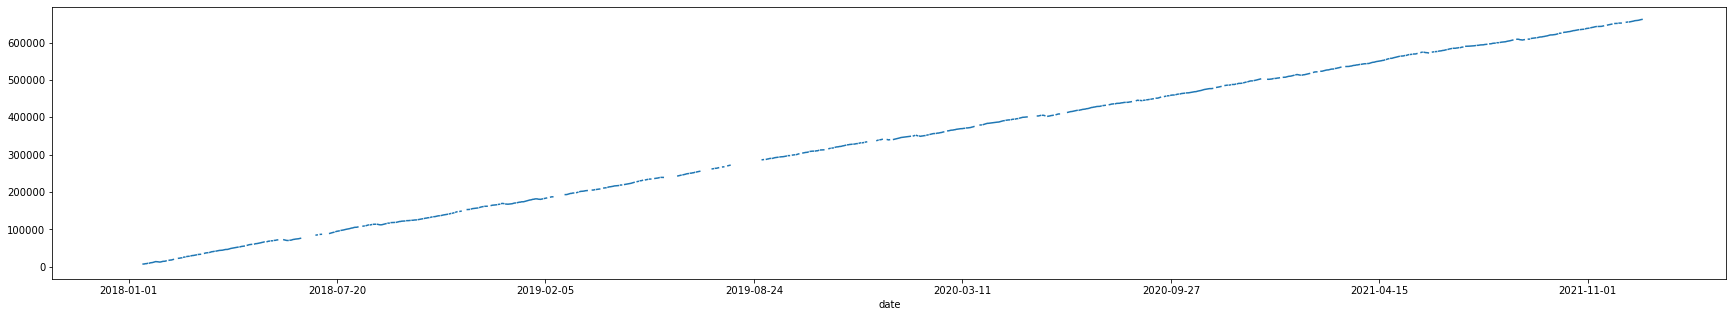

In [3]:
data.set_index('date')['value'].plot(figsize=(30, 5))

<AxesSubplot:xlabel='date'>

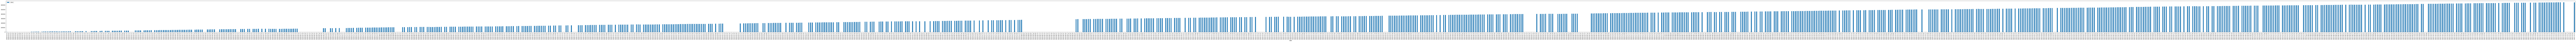

In [4]:
data.plot.bar(x='date', y='value', figsize=(400,5))

## интерполяция

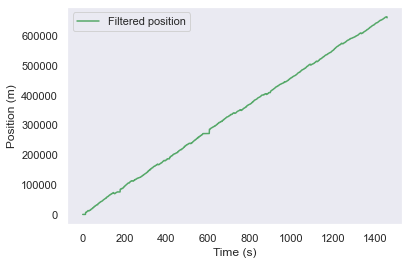

In [56]:
data = pd.read_csv('C:/pythonushka/missing_negative_value.csv')


# Здесь мы делаем последующие значения равными предыдущим, если они меньше предедущих.

#length_colulmn = len(data)
#for i in range(1,length_colulmn):
#    if data['value'].iloc[i]-data['value'].iloc[i-1] <0:
#        data['value'].iloc[i] = data['value'].iloc[i-1] 
#    else: 
#        data['value'].iloc[i] = data['value'].iloc[i]


data['index'] = data.index
data['value'].fillna(0, inplace = True)
# включить или отключить отсутствующие наблюдения
use_mask = 1


Time=[]
X=[]
data['value'].fillna(0, inplace=True)
value = data['value'].to_list()
indexer = data['index'].to_list()


for line in indexer:
    f1  = line
    Time.append(float(f1))

for line1 in value:    
    f2 = line1
    X.append(float(f2))

if (use_mask):
    X = ma.asarray(X)
    X = ma.masked_where(X <= 1, X)


# Конфигурация фильтра

# шаг времени
dt = Time[2] - Time[1]

# переходная матрица

# здесь подобраны параметры изходя из подбора, в котором наши предсказуемые значения не превышали последующих значений  

F = [[1,  1.11*dt, 2*dt*dt], 
     [0,   1,      1.11*dt],
     [0,   0,            1]]  


# матрица наблюдения
H = [1, 0, 0]

# переходная ковариация
Q = [[   1,     0,     0], 
     [   0,  1e-10,     0],
     [   0,     0,  1e-12]] 

# ковариация наблюдения
R = [0] # max error = 0 m

# начальное состояние означает
X0 = [0,
      0,
      0]

# Ковариация начального состояния
P0 = [[  1,    0,   0], 
      [  0,    1,   0],
      [  0,    0,   1]]

n_timesteps = len(Time)
n_dim_state = 3



filtered_state_means = np.zeros((n_timesteps, n_dim_state))
filtered_state_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))

# Инициализация Kalman-Filter
kf = KalmanFilter(transition_matrices = F, 
                  observation_matrices = H, 
                  transition_covariance = Q, 
                  observation_covariance = R, 
                  initial_state_mean = X0, 
                  initial_state_covariance = P0)


# Итеративная оценка для каждого нового измерения

for t in range(n_timesteps):
    filtered_state_means[t], filtered_state_covariances[t] = (
    kf.filter_update(
            filtered_state_means[t-1],
            filtered_state_covariances[t-1],
            observation = X[t])
        )

position_sigma = np.sqrt(filtered_state_covariances[:, 0, 0]);        


# график полученной траектории
plt.plot(Time, filtered_state_means[:, 0], "g-", label="Filtered position", markersize=1)
#plt.plot(Time, filtered_state_means[:, 0] + position_sigma, "r--", label="+ sigma", markersize=1)
#plt.plot(Time, filtered_state_means[:, 0] - position_sigma, "r--", label="- sigma", markersize=2)
plt.grid()
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.show() 

In [57]:
data = pd.read_csv('C:/pythonushka/missing_negative_value.csv')
#print(filtered_state_means[:, 0])
value2 = []
value2.append(filtered_state_means[:, 0])
data['value2'] = filtered_state_means[:, 0]
#print(data)


data['delta'] = data['value2'].T.diff().fillna(0).astype('float64')  
#print(data['delta'])

# Функция покажет если есть предыдущие значения больше последующих

data_delta_age_negative = data [data ['delta'] <0]
data.pop('date')
data.pop('value')
data.pop('delta')
#data['index'] = data.index +1
data['index2'] = data.index +1


print('Наличие значений превышающих последующие:\n', data_delta_age_negative)
data.pop('index2')
data['date'] = data.index

# Эта функция позволит сделать значения ,превышающие последующие, равными им.

#length_colulmn = len(data)

#for i in range(1,length_colulmn):
#    if data['value2'].iloc[i]>data['value2'].iloc[1460]:
#        data['value2'].iloc[i]=data['value2'].iloc[i-1]
#    elif data['value2'].iloc[i]-data['value2'].iloc[i-1] <0:
#        data['value2'].iloc[i] = data['value2'].iloc[i-1]
#    elif data['value2'].iloc[i]-data['value2'].iloc[i+1] <0:
#        data['value2'].iloc[i] = data['value2'].iloc[i-1]   
#    else: 
#        data['value2'].iloc[i] = data['value2'].iloc[i]

data.to_csv('C:/pythonushka/kalman_done.csv', index=False)
data

Наличие значений превышающих последующие:
             date       value      value2        delta
27    2018-01-28   13578.838   13578.838  -179.683000
28    2018-01-29   13266.594   13266.594  -312.244000
29    2018-01-30   12913.685   12913.685  -352.909000
30    2018-01-31   12456.661   12456.661  -457.024000
149   2018-05-30   72223.891   72223.891 -1638.704109
150   2018-05-31   71688.117   71688.117  -535.774000
151   2018-06-01   70851.556   70851.556  -836.561000
152   2018-06-02   70274.352   70274.352  -577.204000
239   2018-08-28  113492.960  113492.960  -290.961617
240   2018-08-29  112850.476  112850.476  -642.484000
241   2018-08-30  112276.897  112276.897  -573.579000
242   2018-08-31  112163.045  112163.045  -113.852000
360   2018-12-27  168940.779  168940.779  -503.405000
362   2018-12-29  167786.634  167786.634 -1155.665553
363   2018-12-30  167456.969  167456.969  -329.665000
364   2018-12-31  167373.030  167373.030   -83.939000
392   2019-01-28  181687.430  181687.43

value2  date
0        784.288000     0
1        784.288000     1
2        784.288000     2
3        784.288000     3
4        784.288000     4
...             ...   ...
1456  662593.703791  1456
1457  662838.108250  1457
1458  663082.731750  1458
1459  663327.574293  1459
1460  659746.694000  1460

[1461 rows x 2 columns]

In [58]:
#data['delta'] = data['value2'].T.diff().fillna(0).astype('float64')  
#print(data['delta'])

# Функция покажет если есть предыдущие значения больше последующих

#data_delta_age_negative = data [data ['delta'] <0]
#print(data_delta_age_negative)

In [59]:
print(data)
print(data.info())

             value2  date
0        784.288000     0
1        784.288000     1
2        784.288000     2
3        784.288000     3
4        784.288000     4
...             ...   ...
1456  662593.703791  1456
1457  662838.108250  1457
1458  663082.731750  1458
1459  663327.574293  1459
1460  659746.694000  1460

[1461 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value2  1461 non-null   float64
 1   date    1461 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 23.0 KB
None


In [60]:
data.set_index('date')['value2'].plot(figsize=(30, 5))

<AxesSubplot:xlabel='date'>

In [61]:
missing = pd.read_csv('C:/pythonushka/missing_negative_value.csv')

w=0.5
x = data['date']
value = data['value2']
value2 = df['value']

#bar1 = np.arange(len(x))
#bar2 = [i+w for i in bar1]

plt.bar(x, value, w, alpha=0.5)
plt.bar(x, value2, w, alpha=0.5)

plt.gcf().set_size_inches(400, 10)
plt.xticks(x, rotation = 90)
plt.show()

In [62]:
data['detvalue'] = data.value2

In [70]:
sns.set()
fig, axes = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(16, 8)
sns.histplot(missing["value"].dropna(), kde = False)
sns.histplot(data['detvalue'], kde = False, color = 'green')
    
plt.tight_layout()

In [71]:
sns.set()
fig, axes = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(16, 8)

df_all = pd.concat([missing, data['detvalue']])
#sns.boxplot(data=result, hue='method')
#df_all = pd.concat([df1,df2])
sns.boxplot(data=df_all)

<AxesSubplot:>

In [72]:
pd.concat([missing[["value"]], data[["detvalue"]]], axis = 1).describe().T

count           mean            std      min           25%  \
value     1094.0  346596.788061  193160.242945  784.288  171681.59025   
detvalue  1461.0  336343.396946  192080.694700  784.288  168940.77900   

                  50%            75%            max  
value     358651.4525  513830.563000  662105.552000  
detvalue  341024.7940  503546.051227  663327.574293

In [66]:
 print(missing["value"].std() - data["detvalue"].std())

1079.5482456645113


# 1079.5482456645113

# Вывод:

Модель хорошая

Мы можем представить себе этот факт разными способами. 
Первый - это построение гистограмм как для неполных, так и для полных данных, 
на которых мы можем заметить, что график полных данных выше и уже по сравнению с графиком неполных данных. 
Другими словами, полные данные имеют меньшее стандартное отклонение (следовательно, меньшую изменчивость), 
чем неполные данные. Другой метод - построить коробчатую диаграмму, 
на которой мы можем наблюдать, что диапазон IQ довольно сжат для полных данных по сравнению с таковым в неполных данных.

### Следовательно этот метод имеет место быть. Им можно пользоваться, но для идеального восстановления данных с большим промежутками он не подходит.